## 1. Importing Dependencies

In this section, the necessary libraries and modules are imported, including scikit-learn (sklearn) for machine learning algorithms, pandas for data manipulation, matplotlib for data visualization, numpy for numerical computations, time for measuring execution time, and seaborn for enhanced visualization.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time
import seaborn as sb
from sklearn.metrics import (
    confusion_matrix, precision_score, recall_score, f1_score,
    roc_curve, precision_recall_curve, accuracy_score, auc, classification_report
)
from sklearn.model_selection import (
    cross_val_score, StratifiedKFold, GridSearchCV, train_test_split
)
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC


## 2: Defining Models and Evaluation Metrics
Here, the models to be evaluated and compared are defined using sklearn's classifiers, namely DecisionTreeClassifier, KNeighborsClassifier, RandomForestClassifier, and SVC. Evaluation metrics such as confusion matrix, precision, recall, accuracy, F1 score, and classification report are also defined.

In [ ]:
# Define the models to evaluate
models = {
    'Decision Tree': DecisionTreeClassifier(),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Support Vector Machines': SVC(probability=True)
}

# Define evaluation metrics
metrics = {
    'Confusion Matrix': confusion_matrix,
    'Precision': precision_score,
    'Recall': recall_score,
    'Accuracy': accuracy_score,
    'F1 Score': f1_score,
    'Classification Report': classification_report
}


## 3: Defining Hyperparameter Grids
This section defines hyperparameter grids for performing grid search on specific models. The grid search is used to find the best combination of hyperparameters for each model, which leads to improved performance.

In [ ]:
# Define hyperparameter grids for grid search
model_params = {
    'Decision Tree': {'max_depth': [None, 5, 10, 15], 'max_features': range(1, 24)},
    'Random Forest': {'n_estimators': [50, 100, 200], 'max_depth': [None, 5, 10, 15], 'max_features': ['sqrt', 'log2']}
}

## 4: Data Preparation
In this section, the input data and corresponding labels are extracted from a CSV file using pandas. Feature scaling is applied to standardize the input data using StandardScaler from sklearn.preprocessing.

In [ ]:
mutation_data_clean = pd.read_csv('data/mutation_data_clean.csv')

# Extract the data and labels
all_inputs = mutation_data_clean[['Gender', 'Age_at_diagnosis', 'Race', 'IDH1', 'TP53', 'ATRX', 'PTEN', 'EGFR', 'CIC',
                                 'MUC16', 'PIK3CA', 'NF1', 'PIK3R1', 'FUBP1', 'RB1', 'NOTCH1', 'BCOR', 'CSMD3', 'SMARCA4',
                                 'GRIN2A', 'IDH2', 'FAT4', 'PDGFRA']].values
all_labels = mutation_data_clean['Grade'].values

# Apply feature scaling
scaler = StandardScaler()
all_inputs_scaled = scaler.fit_transform(all_inputs)

## 5: Model Evaluation and Comparison
The models are evaluated and compared in this section. For each model, the following steps are performed:

* Hyperparameter tuning using GridSearchCV: If a model has specific hyperparameters defined in the model_params dictionary, grid search is performed to find the best hyperparameter values using cross-validation.

* Cross-validation evaluation: The model is evaluated using cross-validation and the mean and standard deviation of the cross-validation scores are calculated.

* Repeated evaluation on training and testing sets: The model is trained and evaluated multiple times on different random splits of the data. The predictions from each repetition are stored and used to calculate evaluation metrics such as accuracy, precision, recall, F1 score, confusion matrix, and classification report.

In [ ]:
# Perform model evaluation and comparison
model_scores = {}
model_times = {}
model_accuracies = {}
grid_searches = {}

repetitions = 10

for model_name, model in models.items():
    scores = {}
    start_time = time.time()

    # Hyperparameter tuning using GridSearchCV
    if model_name in model_params:
        param_grid = model_params[model_name]
        grid_search = GridSearchCV(model, param_grid=param_grid, cv=5, scoring='accuracy')
        grid_search.fit(all_inputs_scaled, all_labels)
        model = grid_search.best_estimator_
        print(f'Best parameters for {model_name}: {grid_search.best_params_}')
        grid_searches[model_name] = grid_search

    # Perform evaluation using cross-validation
    cv_scores = cross_val_score(model, all_inputs_scaled, all_labels, cv=StratifiedKFold(n_splits=10, shuffle=True))
    scores['Cross-Validation Mean'] = np.mean(cv_scores)
    scores['Cross-Validation STD'] = np.std(cv_scores)

    total_predictions = []
    for _ in range(repetitions):
        total_predictions = []  # Reset the list for each repetition

        # Split the data into training and testing sets
        training_inputs, testing_inputs, training_labels, testing_labels = train_test_split(all_inputs_scaled,
                                                                                            all_labels,
                                                                                            test_size=0.2,
                                                                                            stratify=all_labels)

        # Train the model
        model.fit(training_inputs, training_labels)

        # Predict on the testing set
        predictions = model.predict(testing_inputs)
        total_predictions.append(predictions)

    total_predictions = np.array(total_predictions)
    predictions_mean = np.mean(total_predictions, axis=0)
    
    scores['Accuracy'] = accuracy_score(testing_labels, predictions_mean.round().astype(int))
    scores['Precision'] = precision_score(testing_labels, predictions_mean.round().astype(int))
    scores['Recall'] = recall_score(testing_labels, predictions_mean.round().astype(int))
    scores['F1 Score'] = f1_score(testing_labels, predictions_mean.round().astype(int))
    scores['Confusion Matrix'] = confusion_matrix(testing_labels, predictions_mean.round().astype(int))
    scores['Classification Report'] = classification_report(testing_labels, predictions_mean.round().astype(int))
    
    model_scores[model_name] = scores
    model_times[model_name] = time.time() - start_time
    model_accuracies[model_name] = accuracy_score(testing_labels, predictions_mean.round().astype(int))


## 6: Displaying Evaluation Metrics
This section displays the evaluation metrics for each model. It iterates over the model_scores dictionary and prints the evaluation metrics defined in the metrics dictionary.

In [ ]:
# Print the evaluation metrics for each model
for model_name, scores in model_scores.items():
    print(f'\nEvaluation metrics for {model_name}:')
    for metric_name, metric_func in metrics.items():
        if metric_name in scores:
            print(f'{metric_name}:')
            print(scores[metric_name])


## 7: Comparing Models based on Accuracy
Here, a bar plot is created to compare the models based on their accuracies. The model_accuracies dictionary is used to plot the accuracy values.

In [ ]:
# Compare the models based on accuracy
plt.bar(model_accuracies.keys(), model_accuracies.values())
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison of Different Models')
plt.show()


## 8: ROC Curves and Precision-Recall Curves
This section plots the ROC curves and Precision-Recall curves for each model. It uses the best estimators obtained from the grid search (if applicable) to calculate the necessary values for the curves.

In [ ]:
# ROC curves and Precision-Recall curves
plt.figure(figsize=(12, 6))
for model_name, grid_search in grid_searches.items():
    model = grid_search.best_estimator_
    if hasattr(model, 'predict_proba'):
        y_score = model.predict_proba(all_inputs_scaled)[:, 1]
    else:
        y_score = model.decision_function(all_inputs_scaled)
    fpr, tpr, thresholds = roc_curve(all_labels, y_score)
    precision, recall, _ = precision_recall_curve(all_labels, y_score)
    roc_auc = auc(fpr, tpr)
    pr_auc = auc(recall, precision)

    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves')
    plt.legend(loc='lower right')

    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, label=f'{model_name} (AUC = {pr_auc:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curves')
    plt.legend(loc='upper right')

plt.tight_layout()
plt.show()


## 9: Hyperparameter Tuning Results
The results of hyperparameter tuning using grid search are displayed in this section. It iterates over the grid_searches dictionary and prints the hyperparameter tuning results for each model.

In [ ]:
# Hyperparameter tuning results
for model_name, grid_search in grid_searches.items():
    print(f'\nHyperparameter tuning results for {model_name}:')
    cv_results = pd.DataFrame(grid_search.cv_results_)
    print(cv_results[['params', 'mean_test_score', 'std_test_score']])


## 10: Grid Search Line Plots Visualization
In this section, line plots are created to visualize the grid search results for each model. It iterates over the grid_searches dictionary, retrieves the parameter grid and relevant data from cv_results, and plots the mean test scores against the different hyperparameter values.

By splitting the code into these sections and providing explanations, it becomes easier to understand the overall process, the methods used (e.g., cross-validation, hyperparameter tuning), and why they are used to evaluate and compare different machine learning models.

In [ ]:
# Grid search line plots visualization
for model_name, grid_search in grid_searches.items():
    print(f'\nGrid search results for {model_name}:')
    cv_results = pd.DataFrame(grid_search.cv_results_)
    param_grid = grid_search.param_grid

    plt.figure(figsize=(8, 6))
    for max_depth in param_grid['max_depth']:
        data = cv_results[cv_results['param_max_depth'] == max_depth]

        # Check if data is empty
        if not data.empty:
            data = data.sort_values(by='param_max_features')  # Sort data by max_features
            max_features = data['param_max_features']
            mean_test_scores = data['mean_test_score']
            plt.plot(max_features, mean_test_scores, label=f'Max Depth: {max_depth}')

    plt.xlabel('Max Features')
    plt.ylabel('Mean Test Score')
    plt.title(f'{model_name} Grid Search Results')
    plt.legend(loc='lower right')
    plt.show()


## 11: Full code

Best parameters for Decision Tree: {'max_depth': 5, 'max_features': 21}
Best parameters for Random Forest: {'max_depth': 15, 'max_features': 'log2', 'n_estimators': 200}

Evaluation metrics for Decision Tree:
Confusion Matrix:
[[77 20]
 [ 7 91]]
Precision:
0.8198198198198198
Recall:
0.9285714285714286
Accuracy:
0.8615384615384616
F1 Score:
0.8708133971291867
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.79      0.85        97
           1       0.82      0.93      0.87        98

    accuracy                           0.86       195
   macro avg       0.87      0.86      0.86       195
weighted avg       0.87      0.86      0.86       195


Evaluation metrics for K-Nearest Neighbors:
Confusion Matrix:
[[78 20]
 [ 6 91]]
Precision:
0.8198198198198198
Recall:
0.9381443298969072
Accuracy:
0.8666666666666667
F1 Score:
0.875
Classification Report:
              precision    recall  f1-score   support

           0       0.93    

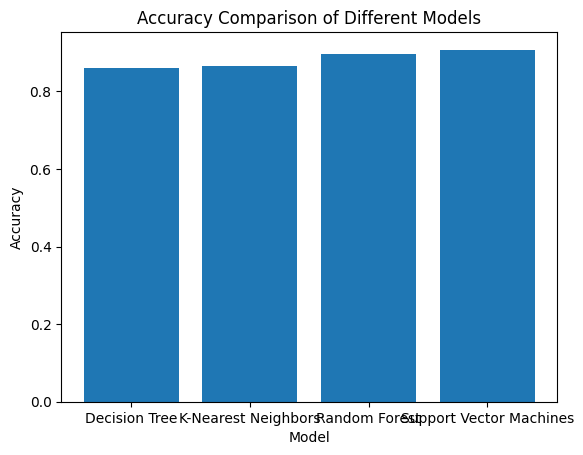

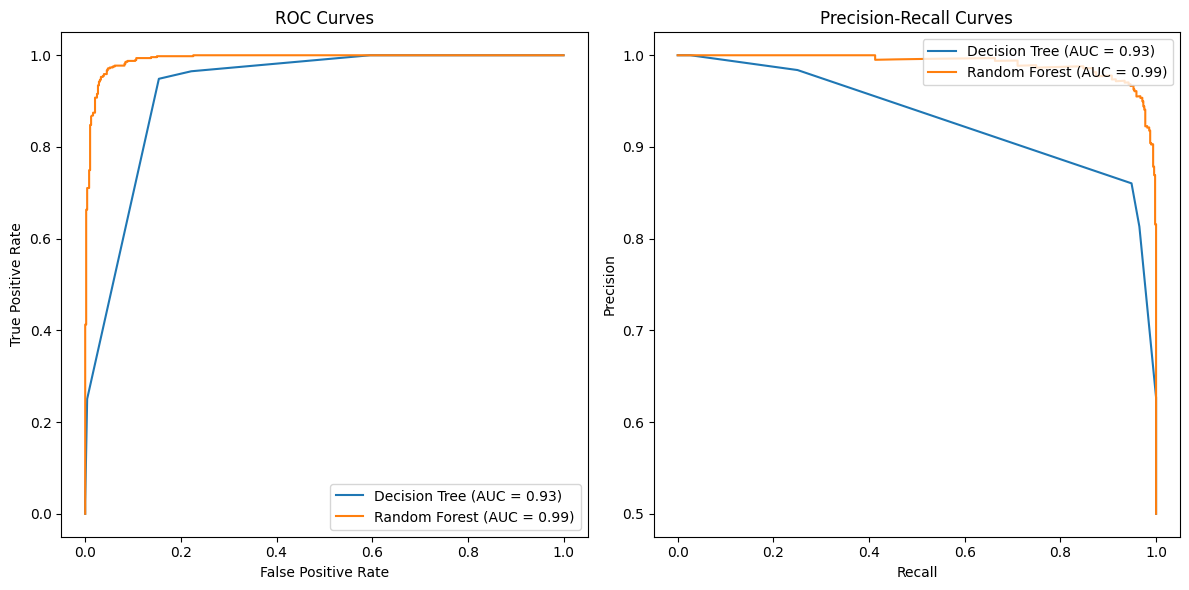


Hyperparameter tuning results for Decision Tree:
                                    params  mean_test_score  std_test_score
0   {'max_depth': None, 'max_features': 1}         0.849125        0.029124
1   {'max_depth': None, 'max_features': 2}         0.851166        0.031813
2   {'max_depth': None, 'max_features': 3}         0.857320        0.025486
3   {'max_depth': None, 'max_features': 4}         0.874771        0.020532
4   {'max_depth': None, 'max_features': 5}         0.870674        0.031233
..                                     ...              ...             ...
87   {'max_depth': 15, 'max_features': 19}         0.861401        0.030576
88   {'max_depth': 15, 'max_features': 20}         0.857335        0.033478
89   {'max_depth': 15, 'max_features': 21}         0.870663        0.030575
90   {'max_depth': 15, 'max_features': 22}         0.854237        0.026541
91   {'max_depth': 15, 'max_features': 23}         0.857309        0.027699

[92 rows x 3 columns]

Hyperparameter

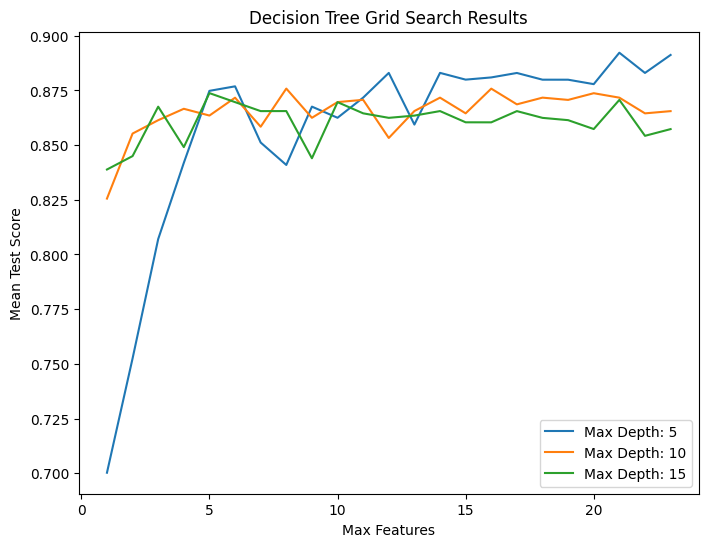


Grid search results for Random Forest:


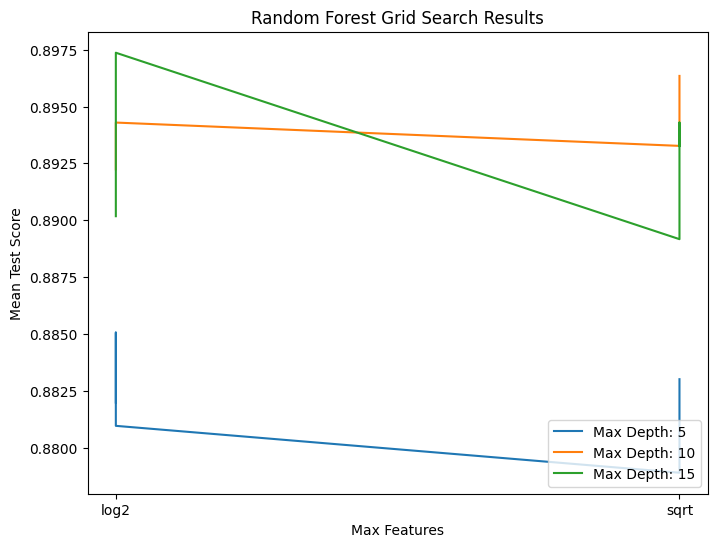

In [93]:
from sklearn.metrics import (
    confusion_matrix, precision_score, recall_score, f1_score,
    roc_curve, precision_recall_curve, accuracy_score, auc, classification_report
)
from sklearn.model_selection import (
    cross_val_score, StratifiedKFold, GridSearchCV, train_test_split
)
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time
import seaborn as sb

# Define the models to evaluate
models = {
    'Decision Tree': DecisionTreeClassifier(),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Support Vector Machines': SVC(probability=True)
}

# Define evaluation metrics
metrics = {
    'Confusion Matrix': confusion_matrix,
    'Precision': precision_score,
    'Recall': recall_score,
    'Accuracy': accuracy_score,
    'F1 Score': f1_score,
    'Classification Report': classification_report
}

# Define hyperparameter grids for grid search
model_params = {
    'Decision Tree': {'max_depth': [None, 5, 10, 15], 'max_features': range(1, 24)},
    'Random Forest': {'n_estimators': [50, 100, 200], 'max_depth': [None, 5, 10, 15], 'max_features': ['sqrt', 'log2']}
}

# Perform model evaluation and comparison
model_scores = {}
model_times = {}
model_accuracies = {}
grid_searches = {}

mutation_data_clean = pd.read_csv('data/mutation_data_clean.csv')

# Extract the data and labels
all_inputs = mutation_data_clean[['Gender', 'Age_at_diagnosis', 'Race', 'IDH1', 'TP53', 'ATRX', 'PTEN', 'EGFR', 'CIC',
                                 'MUC16', 'PIK3CA', 'NF1', 'PIK3R1', 'FUBP1', 'RB1', 'NOTCH1', 'BCOR', 'CSMD3', 'SMARCA4',
                                 'GRIN2A', 'IDH2', 'FAT4', 'PDGFRA']].values
all_labels = mutation_data_clean['Grade'].values

# Apply feature scaling
scaler = StandardScaler()
all_inputs_scaled = scaler.fit_transform(all_inputs)

repetitions = 10

for model_name, model in models.items():
    scores = {}
    start_time = time.time()

    # Hyperparameter tuning using GridSearchCV
    if model_name in model_params:
        param_grid = model_params[model_name]
        grid_search = GridSearchCV(model, param_grid=param_grid, cv=5, scoring='accuracy')
        grid_search.fit(all_inputs_scaled, all_labels)
        model = grid_search.best_estimator_
        print(f'Best parameters for {model_name}: {grid_search.best_params_}')
        grid_searches[model_name] = grid_search

    # Perform evaluation using cross-validation
    cv_scores = cross_val_score(model, all_inputs_scaled, all_labels, cv=StratifiedKFold(n_splits=10, shuffle=True))
    scores['Cross-Validation Mean'] = np.mean(cv_scores)
    scores['Cross-Validation STD'] = np.std(cv_scores)

    total_predictions = []
    for _ in range(repetitions):
        total_predictions = []  # Reset the list for each repetition

        # Split the data into training and testing sets
        training_inputs, testing_inputs, training_labels, testing_labels = train_test_split(all_inputs_scaled,
                                                                                            all_labels,
                                                                                            test_size=0.2,
                                                                                            stratify=all_labels)

        # Train the model
        model.fit(training_inputs, training_labels)

        # Predict on the testing set
        predictions = model.predict(testing_inputs)
        total_predictions.append(predictions)

    total_predictions = np.array(total_predictions)
    predictions_mean = np.mean(total_predictions, axis=0)
    
    scores['Accuracy'] = accuracy_score(testing_labels, predictions_mean.round().astype(int))
    scores['Precision'] = precision_score(testing_labels, predictions_mean.round().astype(int))
    scores['Recall'] = recall_score(testing_labels, predictions_mean.round().astype(int))
    scores['F1 Score'] = f1_score(testing_labels, predictions_mean.round().astype(int))
    scores['Confusion Matrix'] = confusion_matrix(testing_labels, predictions_mean.round().astype(int))
    scores['Classification Report'] = classification_report(testing_labels, predictions_mean.round().astype(int))
    
    model_scores[model_name] = scores
    model_times[model_name] = time.time() - start_time
    model_accuracies[model_name] = accuracy_score(testing_labels, predictions_mean.round().astype(int))

# Print the evaluation metrics for each model
for model_name, scores in model_scores.items():
    print(f'\nEvaluation metrics for {model_name}:')
    for metric_name, metric_func in metrics.items():
        if metric_name in scores:
            print(f'{metric_name}:')
            print(scores[metric_name])

# Compare the models based on accuracy
plt.bar(model_accuracies.keys(), model_accuracies.values())
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison of Different Models')
plt.show()

# ROC curves and Precision-Recall curves
plt.figure(figsize=(12, 6))
for model_name, grid_search in grid_searches.items():
    model = grid_search.best_estimator_
    if hasattr(model, 'predict_proba'):
        y_score = model.predict_proba(all_inputs_scaled)[:, 1]
    else:
        y_score = model.decision_function(all_inputs_scaled)
    fpr, tpr, thresholds = roc_curve(all_labels, y_score)
    precision, recall, _ = precision_recall_curve(all_labels, y_score)
    roc_auc = auc(fpr, tpr)
    pr_auc = auc(recall, precision)

    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves')
    plt.legend(loc='lower right')

    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, label=f'{model_name} (AUC = {pr_auc:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curves')
    plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

# Hyperparameter tuning results
for model_name, grid_search in grid_searches.items():
    print(f'\nHyperparameter tuning results for {model_name}:')
    cv_results = pd.DataFrame(grid_search.cv_results_)
    print(cv_results[['params', 'mean_test_score', 'std_test_score']])

# Grid search line plots visualization
for model_name, grid_search in grid_searches.items():
    print(f'\nGrid search results for {model_name}:')
    cv_results = pd.DataFrame(grid_search.cv_results_)
    param_grid = grid_search.param_grid

    plt.figure(figsize=(8, 6))
    for max_depth in param_grid['max_depth']:
        data = cv_results[cv_results['param_max_depth'] == max_depth]

        # Check if data is empty
        if not data.empty:
            data = data.sort_values(by='param_max_features')  # Sort data by max_features
            max_features = data['param_max_features']
            mean_test_scores = data['mean_test_score']
            plt.plot(max_features, mean_test_scores, label=f'Max Depth: {max_depth}')

    plt.xlabel('Max Features')
    plt.ylabel('Mean Test Score')
    plt.title(f'{model_name} Grid Search Results')
    plt.legend(loc='lower right')
    plt.show()



